### Predição de notas de filmes -  Análise Exploratória de Dados

Descrição dos atributos

**Series_Title** – Nome do filme

**Released_Year** - Ano de lançamento

**Certificate** - Classificação etária

**Runtime** – Tempo de duração

**Genre** - Gênero

**IMDB_Rating**- Nota do IMDB

**Overview**- Overview do filme

**Meta_score**- Média ponderada de todas as críticas 

**Director** – Diretor

**Star1**- Ator/atriz #1

**Star2**- Ator/atriz #2

**Star3**- Ator/atriz #3

**Star4**- Ator/atriz #4

**No_of_Votes**- Número de votos

**Gross**- Faturamento


In [ ]:
#Import de bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import textwrap


#### Leitura do arquivo

In [2]:
df = pd.read_csv('desafio_indicium_imdb.csv',sep=',')

In [3]:
df.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


#### Informações sobre a estrutura dos dados

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


#### Pré-Processamento de dados

In [5]:

# Conversão dos atributos para tipos mais adequados para análises
# A coluna 'Unnamed' será renomeada, para ficar mais intuitiva
df.rename(columns={'Unnamed: 0': 'IdUsuario'}, inplace=True)

# A coluna 'Relesad_Year' deve ser tipo numérico 
# Foi verificado que havia um ano faltante (após pesquisa externa) o valor foi substituído pelo ano correto
df['Released_Year'] = df['Released_Year'].replace('PG', 1995)
# Para converter para o tipo correto, por ser uma string é necessário extrair os 4 valores juntos e depois aplicar a conversão
df["Released_Year"] = df["Released_Year"].astype("string").str.extract(r"(\d{4})",expand=False).astype("Int16") 

# A coluna 'Runtime' pode ser tipo int16 
df["Runtime"] = (df["Runtime"].astype("string").str.replace(r"\D", "", regex=True).astype("Int16"))

# A coluna 'IMDB_Rating' pode ser tipo float32
df['IMDB_Rating'] = df['IMDB_Rating'].astype('float32')

# A coluna 'Meta_score' pode tipo inteiro Int32
df['Meta_score'] = df['Meta_score'].astype('Int32')

# A coluna 'No_of_votes" pode ser tipo Int32
df['No_of_Votes'] = df['No_of_Votes'].astype('Int32')

# A coluna 'Gross' deve ser tipo float64 
# Para converter para o tipo correto, por ser uma string com ',' é necessário removê-la antes
df["Gross"] = (df["Gross"].str.replace(r"[^0-9-]", "", regex=True) .astype("float64"))


In [6]:
# Verificação de valores nulos
df.isnull().sum()

#Verificação de linhas duplicadas
print('Existem valores duplicados: \n',df.duplicated().any())

Existem valores duplicados: 
 False


#### Tratamento de dados ausentas 

##### Coluna ['Certificate']

Os valores presentes na coluna 'Certificate', contém classificações de diferentes países. Para padronizar foi  realizado um mapeamento com base nas informações obtidas pelo site do IMDb <https://help.imdb.com/article/contribution/titles/certificates/GU757M8ZJ9ZPXB39?ref_=helpms_helpart_inline#>
Dessa forma, rótulos que indicam orientação dos pais foram convertidos para maiores de 10 anos, rótulos numéricos foi mantido a lógica numérica e para valores que estavam  como "Aprovado", "Passou" e "Não classificado", foram tratados como sem classificação. 

Vale ressaltar que o sistema de classificação cinematográfica entraram em vigor a partir de 1968, e há filmes no dataset anteriores a essa data, o que pode explicar filmes não classifciados nos rótulos originais.

In [7]:
#Conversão de rótulos
nova_classificacao = {
    "G": "Livre",
    "PG": "Maiores de 10",
    "PG-13": "Maiores de 12",
    "R": "Maiores de 17",
    "GP": "Sem classificação",
    "TV-PG": "Maiores de 10",
    "TV-14": "Maiores de 14",
    "TV-MA": "Maiores de 18",
    "U": "Livre",
    "A": "Maiores de 18",
    "UA": "Maiores de 10",
    "U/A": "Maiores de 10",
    "Approved": "Sem classificação",
    "Passed": "Sem classificação",
    "Unrated": "Sem classificação",
    "16": "Maiores de 16",
}

# Aplicando a conversão
df["Certificate_Atualizado"] = (df["Certificate"].astype("string").str.strip().map(nova_classificacao))
df = df.drop(columns=['Certificate'])



Para tratar 55 dos valores ausentes na coluna 'Certificate', aplicou-se uma regra baseada no contexto histórico. Foi considerado o ano em que se iniciou o sistema de classificação de filmes (1968) e os títulos lançados antes dessa data com classificação nula foram filtrados. A esses registros foi atribuído o rótulo "Sem Classificação", refletindo que eles são anteriores ao início do sistema vigente.

In [8]:
#Verificação dos valores nulos

# Ano
# Verifica valores nan na coluna de Certificação
cert_nan = df["Certificate_Atualizado"].isna()

# filtro baseado nos valores ausentes e no ano
filtro_ano = df["Released_Year"].notna() & (df["Released_Year"] < 1968)

# Junção das duas condições 
# df_certificate = df[cert_nan & filtro_ano]
# df_certificate.head()

In [9]:
# Substitui os valroes com base no resultado anterior 
# Filtra os valores nulos & antes do ano 1968
filtro_condicao_1 = (df["Certificate_Atualizado"].isna()) & (df["Released_Year"] < 1968)

# Aplica a substituição somente onde a condição foi atendida
df.loc[filtro_condicao_1, 'Certificate_Atualizado'] = 'Sem classificação'

Para os demais casos ausentas, realizou-se uma pesquisa online por título para obter a classificação indicativa correspondente e atualizar a coluna Certificate Atulizado.

In [10]:
#Verificação dos valores nulos

#Título 
# Verifica valores nan na coluna de Certificação
cert_nan = df["Certificate_Atualizado"].isna()

# filtro baseado nos valores ausentes e no título
titulos_sem_certificado = df.loc[cert_nan, 'Series_Title']
# titulos_sem_certificado

In [11]:
classificao_nan = {
    "Ayla: The Daughter of War": "Maiores de 14",
    "Babam ve Oglum": "Maiores de 12",
    "Mandariinid": "Maiores de 12",
    "Eskiya": "Maiores de 14",
    "Kis Uykusu": "Maiores de 12",
    "Mary and Max": "Maiores de 12",
    "Underground": "Maiores de 16",
    "Tropa de Elite 2: O Inimigo Agora é Outro": "Maiores de 16",
    "Nefes: Vatan Sagolsun": "Maiores de 16",
    "G.O.R.A.": "Maiores de 12",
    "Vozvrashchenie": "Maiores de 12",
    "Yeopgijeogin geunyeo": "Maiores de 12",
    "Vizontele": "Maiores de 12",
    "Knockin' on Heaven's Door": "Maiores de 14",
    "Bir Zamanlar Anadolu'da": "Maiores de 14",
    "4 luni, 3 saptamâni si 2 zile": "Maiores de 18",
    "The Man from Earth": "Maiores de 12",
    "C.R.A.Z.Y.": "Maiores de 16",
    "Aguirre, der Zorn Gottes": "Maiores de 14",
    "Night of the Living Dead": "Maiores de 14",
    "Perfetti sconosciuti": "Maiores de 14",
    "La grande bellezza": "Maiores de 14",
    "Kokuhaku": "Maiores de 16",
    "Ang-ma-reul bo-at-da": "Maiores de 18",
    "Chugyeokja": "Maiores de 18",
    "Druk": "Maiores de 16",
    "Auf der anderen Seite": "Maiores de 16",
    "Ondskan": "Maiores de 16",
    "Gongdong gyeongbi guyeok JSA": "Maiores de 14",
    "Hana-bi": "Maiores de 16",
    "Naked": "Maiores de 18",
    "God's Own Country": "Maiores de 18",
    "The Broken Circle Breakdown": "Maiores de 16",
    "Detachment": "Maiores de 16",
    "Beasts of No Nation": "Maiores de 18",
    "Death Note: Desu nôto": "Maiores de 14",
    "This Is England": "Maiores de 16",
    "Happiness": "Maiores de 18",
    "Spoorloos": "Maiores de 16",
    "Victoria": "Maiores de 16",
    "El cuerpo": "Maiores de 14",
    "Celda 211": "Maiores de 18",
    "Die Welle": "Maiores de 14",
    "The Secret of Kells": "Maiores de 10",
    "Dead Man's Shoes": "Maiores de 18",
    "Batoru rowaiaru": "Maiores de 18",
}

for titulo, classe in classificao_nan.items():
    df.loc[(df["Series_Title"] == titulo) & (df["Certificate_Atualizado"].isna()),"Certificate_Atualizado"] = classe

##### Coluna ['Meta_score']

A análise da coluna 'meta_score' revela que a média (aprox. 77) e a mediana (79) são muito próximas, o que é um forte indício de uma distribuição simétrica. Por ser uma medida menos afetada por valores extremos e representar o centro dos dados, optou-se por substituir todos os valores ausentes pela mediana (79). Essa abordagem preserva a tendência central da distribuição de forma consistente.

In [12]:
#Verifica a distribuição estatística da coluna meta_score
display(df['Meta_score'].describe())

# Calcula o valor da mediana dos valores presentes
mediana_score = df['Meta_score'].median()
# Substitui o resultado anterior no valores ausentes
df['Meta_score'] = df['Meta_score'].fillna(mediana_score)

count        842.0
mean     77.969121
std      12.383257
min           28.0
25%           70.0
50%           79.0
75%           87.0
max          100.0
Name: Meta_score, dtype: Float64

##### Coluna ['Gross']

Considerando a assimetria na distribuição do faturamento, optou-se por aplicar uma imputação por grupos. Neste caso, foi calculado a mediana em cada grupo definido por ano de lançamento e avaliação no IMDb e a substitui nos valores ausentes. A ideia é que filmes do mesmo ano e com avaliações semelhantes tendem a apresentar faixas de faturamento próximas.

In [13]:
#Verifica a distribuição estatística da coluna faturamento 
df['Gross'].describe()

count    8.300000e+02
mean     6.808257e+07
std      1.098076e+08
min      1.305000e+03
25%      3.245338e+06
50%      2.345744e+07
75%      8.087634e+07
max      9.366622e+08
Name: Gross, dtype: float64

In [14]:
# Calcula  mediana por grupo (ano, nota IMDb) e agrupa com faturamento
mediana_ano_nota = df.groupby(["Released_Year", "IMDB_Rating"])["Gross"].transform("median")

# Aplica o resultado anterior na coluna
df["Gross"] = (df["Gross"].fillna(mediana_ano_nota).median())

### Análise Exploratória dos dados

#### Lançamentos de filmes por ano - a partir de 1980


Top 5 anos com mais lançamentos:
Released_Year
2014    32
2004    31
2009    29
2013    28
2016    28
dtype: int64


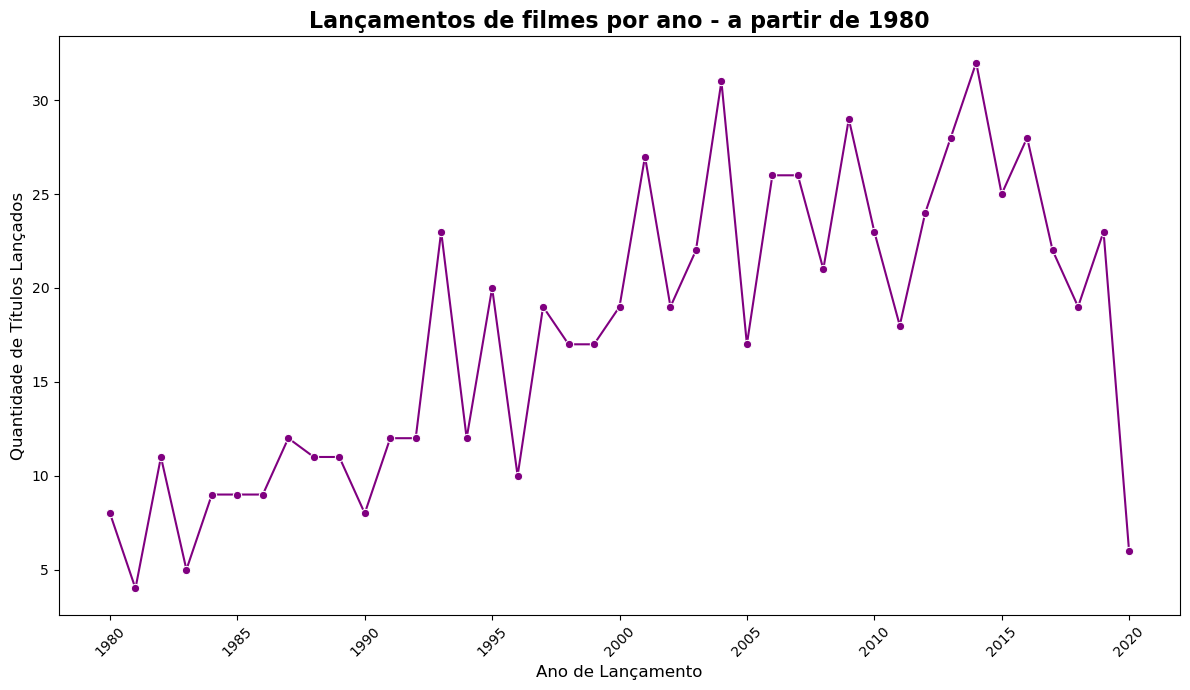

In [15]:
#Lançamentos de filmes por ano - a partir de 1980

# Filtra filmes com data de lançamento após o ano d 1980
df_apos_1980 = df[df['Released_Year'] >= 1980]

# Relaciona os dados já filtrados e conta a quatidade de títulos
titulos_por_ano = df_apos_1980.groupby('Released_Year').size()

print("\nTop 5 anos com mais lançamentos:")
print(titulos_por_ano.nlargest(5))

# Gráfico de linhas
plt.figure(figsize=(12, 7))
sns.lineplot(x=titulos_por_ano.index, y=titulos_por_ano.values, marker='o', linestyle='-', color='purple')
plt.title('Lançamentos de filmes por ano - a partir de 1980', fontsize=16, weight='bold')
plt.xlabel('Ano de Lançamento', fontsize=12)
plt.ylabel('Quantidade de Títulos Lançados', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Conclusões:**

Com o intuito de observar a evolução recente, foram analisados os lançamentos a partir de 1980. No dataset, os anos com mais títulos foram 2014 (32), 2004 (31), 2009 (29), 2013 (28) e 2016 (28). De modo geral, as diferenças são pequenas, mas podem refletir uma representatividade do conjunto em algumas épocas. A queda acentuada em 2020 reflete não só as paralisações na produção causadas pela pandemia, mas também o adiamento de lançamentos.

Ao analisar o ínicio do boom, pode-se inferir que  número de filmes presentes no dataset cresce a partir dos anos 80, sugerindo que filmes produzidos nesse período têm maior popularidade nesta seleção específica. Esse aumento pode ser associado à popularização do cinema, à abertura de novos mercados, ao fortalecimento de franquias e à maior distribuição.  Atualmente, com as plataformas de streaming, essa tendência é esse crescimento se intensificar.


#### Top 5 filmes mais bem avaliados

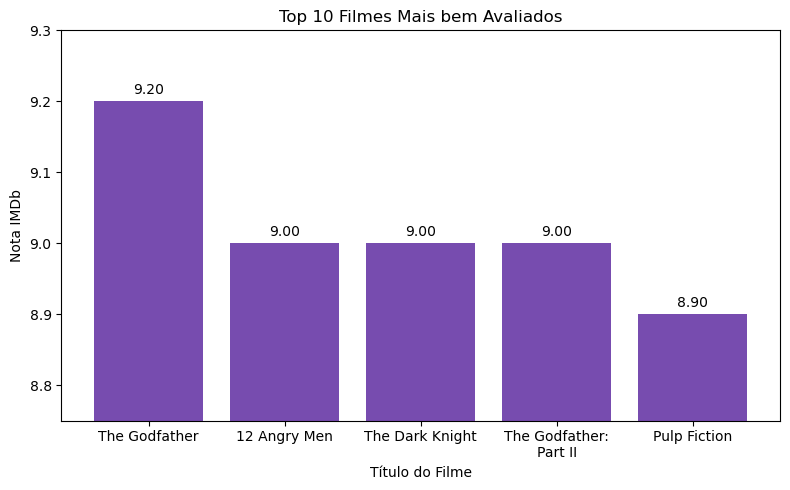

In [16]:
#### Top 5 filmes mais bem avaliados

# Seleciona e ordem em ordem descrecente os filmes de acordo com o titulo (em caso de empate, vai por ordem alfabética)
top5 = (df.sort_values(['IMDB_Rating', 'Series_Title'], ascending=[False, True])      
         .loc[:, ['Series_Title', 'IMDB_Rating']]
         .head(5)
         .reset_index(drop=True))

# Titulos dos textos
titles  = [textwrap.fill(t, width=18) for t in top5['Series_Title']]
ratings = top5['IMDB_Rating'].values
x = np.arange(len(top5))

fig, ax = plt.subplots(figsize=(8, 5))

# Gráfico de barras
bars = ax.bar(x, ratings, linewidth=0.6, color="#774CAF")
ax.grid(False)

# Adaptação da escala no eixo Y para destacar diferenças das notas
ymin = max(ratings.min() - 0.15, 0)
ymax = min(ratings.max() + 0.10, 10)
ax.set_ylim(ymin, ymax)

# Rótulos numéricos nas barras 
ax.bar_label(bars, labels=[f"{v:.2f}" for v in ratings], padding=3, fontsize=10)

# Títulos e eixos
ax.set_title("Top 10 Filmes Mais bem Avaliados")
ax.set_xlabel("Título do Filme")
ax.set_ylabel("Nota IMDb")
ax.set_xticks(np.arange(len(titles)))
ax.set_xticklabels(titles, rotation=0, ha="center")
plt.tight_layout()
plt.show()


**Conclusões:**

A análise dos filmes mais bem avaliados do dataset revela um perfil de público com um gosto refinado e uma forte inclinação para os clássicos. Os top 5 é predomiado por obras marcantes como The Godfather com nota 9.2, seguido de perto pelo um trio 12 Angry Men, The Dark Knight e The Godfather: Part II todos com nota 9.0 e para completar Pulp Fiction com 8.9.

A  presença desses títulos não é coincidência. Ela indica que público do conjunto de dados valoriza roteiros complexos e uma direção marcante, como os diretores Coppola, Lumet, Nolan e Tarantino. Do ponto de vista temático, nota-se que há uma preferênia sobre assuntos relacioandos a crimes, justiça, anti-herois por exemplo. Isso sugere que os usuários deste dataset possivelmente buscam filmes com  narrativas com alta complexidade moral e representações de violência.

#### Top 5 Diretores com Maior Faturamento Total

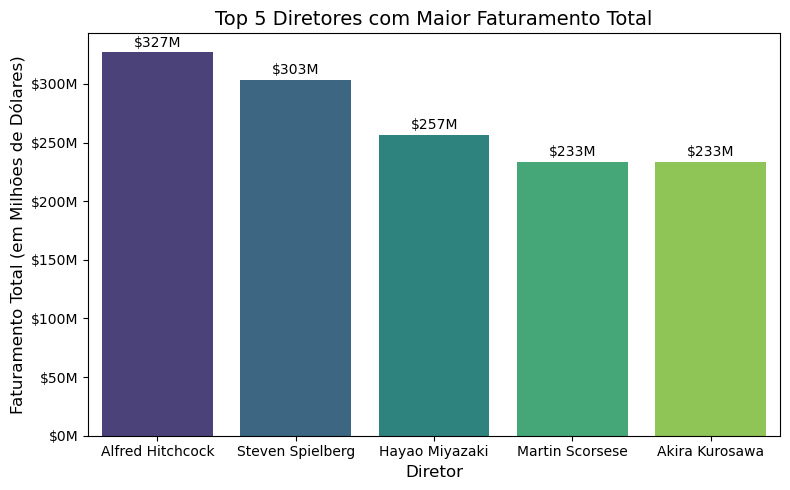

In [17]:
# Top 5 Diretores com Maior Faturamento Total

# Agrupando Diretor e Farutamento
faturamento_por_diretor = (df.groupby('Director')['Gross'].sum().sort_values(ascending=False))

# Selecionado os top 5
top_5_diretores = faturamento_por_diretor.head(5)

# Plotando gráfico 
plt.figure(figsize=(8, 5))

ax = sns.barplot(
    x=top_5_diretores.index, 
    y=top_5_diretores.values,
    hue=top_5_diretores.index,  
    palette='viridis', 
    legend=False
)

# Titulos e eixos 
ax.set_title('Top 5 Diretores com Maior Faturamento Total', fontsize=14)
ax.set_xlabel('Diretor', fontsize=12) 
ax.set_ylabel('Faturamento Total (em Milhões de Dólares)', fontsize=12)
plt.xticks(rotation=0, ha='center') 

# Função para unidade milhoes
def fmt_m(x):
    return f'${x/1e6:,.0f}M'  

# aplica no eixo Y
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: fmt_m(x)))

# rótulos nas barras 
for c in ax.containers:
    ax.bar_label(c, labels=[fmt_m(bar.get_height()) for bar in c], padding=2)

plt.tight_layout()
plt.show()

**Conclusões:**

A análise de faturamento por diretor neste dataset mostra  uma correlação direta entre a quantidade de filmes na amostra e a arrecadação total. Alfred Hitchcock lidera o ranking, somando US$ 327 milhões com seus 14 filmes presentes na coleção. Em seguida, aparecem Steven Spielberg (US$ 303M com 13 filmes), Hayao Miyazaki (US$ 257M com 11 filmes) e, empatados, Martin Scorsese e Akira Kurosawa (US$ 233M com 10 filmes cada).

É importante notar que este ranking não reflete o sucesso de bilheteria global, mas sim um possível viés da própria amostragem. Uma vez que, a posição de Steven Spielberg abaixo de Hitchcock, por exemplo, mesmo com o seu sucesso de bilheteria.  Dessa forma, as conclusões sobre o faturamento devem ser interpretadas considerando o contexto deste conjunto de dados.


#### Top 5 Classificações com Maior Engajamento

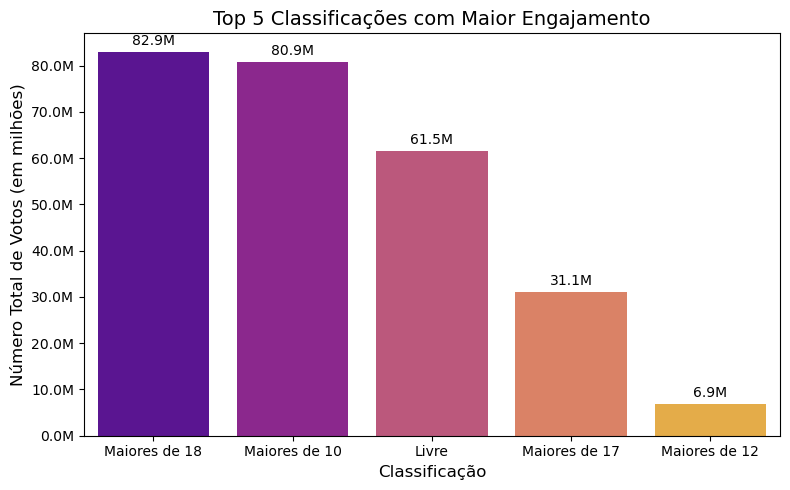

In [18]:
#### Top 5 Classificações com Maior Engajamento

# Agrupa Classificação e Quantidade de Votos
engajamento_classificacao = df.groupby('Certificate_Atualizado')['No_of_Votes'].sum().sort_values(ascending=False)

# Seleciona as top 5 classificações 
top_5_clases = engajamento_classificacao.head(5)

#Gráfico
plt.figure(figsize=(8,5))

ax = sns.barplot(
    x=top_5_clases.index, 
    y=top_5_clases.values,
    hue=top_5_clases.index,  
    palette='plasma', 
    legend=False
)

# Titulos e eixos 
ax.set_title('Top 5 Classificações com Maior Engajamento', fontsize=14)
ax.set_xlabel('Classificação', fontsize=12)
ax.set_ylabel('Número Total de Votos (em milhões)', fontsize=12)
plt.xticks(rotation=0, ha='center') 


# Função para unidade milhoes
def fmt_m(x):
    return f'{x/1e6:.1f}M'

# aplica no eixo Y
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: fmt_m(x)))

# rótulos nas barras 
for c in ax.containers:
    ax.bar_label(c,labels=[fmt_m(bar.get_height()) for bar in c], fontsize=10, padding=3)
plt.tight_layout()
plt.show()


**Conclusões:**

A análise de engajamento por classificação etária indica que o interesse do público neste dataset se concentra em dois extremos: conteúdo adulto e conteúdo infantil. A categoria "Maiores de 18 anos" lidera em volume total de votos (82.9M), mas é seguida de perto por "Maiores de 10 anos" (80.9M) e "Livre" (61.5M), demonstrando que o engajamento não cresce linearmente com a restrição de idade.

É fundamental destacar que os dados carregam um viés da metodologia. A existência de categorias quase idênticas, como "Maiores de 17 anos" (37.1M) e "Maiores de 18 anos", é resultado da adaptação de diferentes sistemas de classificação internacionais. Isso reforça que a análise reflete as características desta amostra específica. Portanto, pode-se concluir que neste conjunto de dados, tanto produções de nicho adulto quanto filmes de classificação 'Livre' demonstram alta capacidade de gerar engajamento.

#### Top 5 Gêneros por Faturamento Total

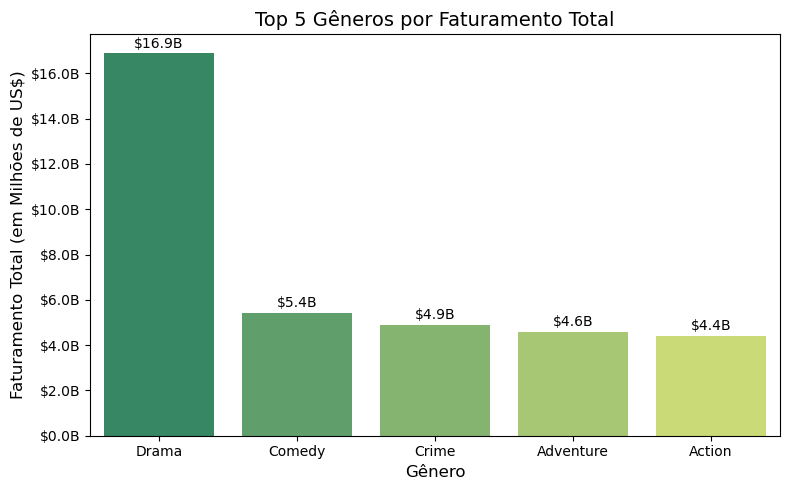

In [19]:
#### Top 5 Gêneros por Faturamento Total

# Dentro da coluna gênero, em um mesmo filme pode haver mais de um tipo, para captar os gêneros isolados é necessário
# realizar o split , e assim um mesmo filme aparece o número de gêneros que tiver
df['Genre_split'] = df['Genre'].str.split(',')
df_generos_separados = df.explode('Genre_split')
df_generos_separados['Genre_split'] = df_generos_separados['Genre_split'].str.strip()

# Agrupa Gênero divido e Faturamento
faturamento_por_genero = df_generos_separados.groupby('Genre_split')['Gross'].sum().sort_values(ascending=False)

# Seleciona as top 5 classificações 
top_5_generos = faturamento_por_genero.head(5)

#Gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=top_5_generos.index,
    y=top_5_generos.values,
    hue=top_5_generos.index,
    palette='summer',
    legend=False
)

# Titulos e eixos 
ax.set_title('Top 5 Gêneros por Faturamento Total', fontsize=14)
ax.set_xlabel('Gênero', fontsize=12)
ax.set_ylabel('Faturamento Total (em Milhões de US$)', fontsize=12)
plt.xticks(rotation=0, ha='center')

# Função para unidade 
def fmt_b(x):
    return f'${x/1e9:,.1f}B'

# aplica no eixo Y
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: fmt_b(x)))

# rótulos nas barras
for c in ax.containers:
    ax.bar_label(c, labels=[fmt_b(bar.get_height()) for bar in c], padding=2)

plt.tight_layout()
plt.show()

**Conclusões:**

Esta análise é fundamental para entender as preferências do público do dataset, e os resultados apontam para um claro favoritismo  do gênero Drama. O faturamento do Drama chega a aproximadamente US$ 16.9 bilhões, colocando-o no topo da lista.

Em seguida, aparecem gêneros Comédia (US$5.4B),Crime (US$4.9B), com Aventura (US$ 4.6 B) e Ação (US$ 4.4B). É importante ressaltar que a análise contabilizou o faturamento para cada gênero individual de um filme. A liderança do "Drama" é impulsionada tanto por filmes puramente dramáticos quanto por sua presença  em outros sucessos de bilheteria (como por exemplo filmes de crime ou biográficos).

Portanto, a preferência do público desta amostra incide sobre narrativas com forte desenvolvimento de personagens e conflitos, características predominantes do gênero Drama, que provou ser a base do faturamento do cinema representado neste conjunto.

In [20]:
# Salva em CSV
df.to_csv("dataset_modelo_ml.csv", index=False)
print("Arquivo Salvo")

Arquivo Salvo


**Considerações Finais:**

A análise geral deste conjunto de dados revela que ele representa uma amostra do mercado cinematográfico. Prova disso é que diretores com histórico de grandes bilheterias, como Steven Spielberg, não aparecem em primeiro lugar no faturamento total — sinal de viés de amostragem, já que o somatório considera apenas os filmes presentes no recorte.

O perfil de público em sua maioria é pelo gênero Drama e Comédia que lideram em faturamento, também mostrou que os picos de engajamento (volume de votos) tanto para maiores de 18 quanto para classificações Livre e as preferências pelos clássicos que englobam temas como crime e dilemas de justiça. 

Portanto, um filme de sucesso nesta amostra é aquele que possui uma nota alta no IMDb (avalização do público), impacto cultural (pessoas engajadas) e bom retorno financeiro. Contudo, vale salientar que todas as conclusões foram observadas dentro desse conjunto. O dataset possui muitas informações relevantes para auxiliar o processo de aprendizado de máquina para prever notas do IMDB.